In [1]:
%reset -f
import time
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


## 0. Solutions to the TOV-Equations and Source/Matter Terms

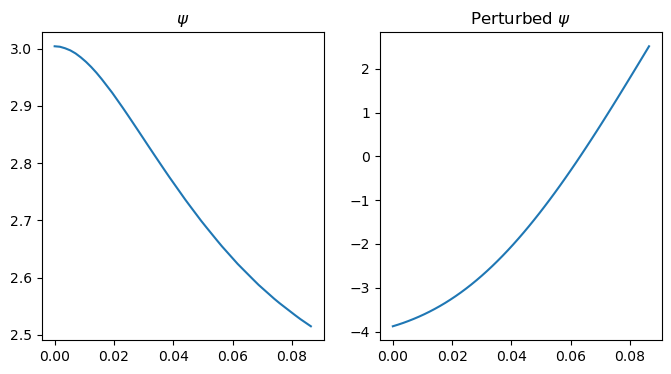

In [2]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'../../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
filename    = f'../../data/tov_112.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Interpolate all the data (in oversampled form) to allow for a linear grid
m_intp     = interpolate.interp1d(R, m,     kind='linear', bounds_error=False)
P_intp     = interpolate.interp1d(R, P,     kind='linear', bounds_error=False)
rho_intp   = interpolate.interp1d(R, rho,   kind='linear', bounds_error=False)
alpha_intp = interpolate.interp1d(R, alpha, kind='linear', bounds_error=False)
psi_intp   = interpolate.interp1d(R, psi,   kind='linear', bounds_error=False)

# Convert to linear grid
nb_points = 50
R = np.linspace(np.min(R), np.max(R), nb_points)

m      = m_intp(R)
P      = P_intp(R)
rho    = rho_intp(R)
alpha  = alpha_intp(R)
psi    = psi_intp(R)

# A large perturbation can be used as an initialization of psi
# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e1      # Scale factor

# Construction of the perturbation
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))
psi_perturbation = gaussian * R_centered

# Define the perturbed density
perturbed_psi = psi + psi_perturbation

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(R, psi)
ax[0].set_title(r"$\psi$")
ax[1].plot(R, perturbed_psi)
ax[1].set_title(r"Perturbed $\psi$");

## 1. Problem Definition

Given the perturbation on the density, the vector equations are trivially zero.

We focus immediately on the nonlinear ODE:
\begin{equation}
\nabla^{2} \psi = \frac{S_{1}}{\psi} + \frac{S_{7}}{\psi^7}
\end{equation}
which we will solve in an iterative fashion as we will compute $\psi_{(n+1)}$ in iteration $n+1$ based on the previous estimate $\psi_{(n)}$ in iteration $n$:
\begin{equation}
\nabla^{2} \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}} + \frac{S_{7}}{\psi_{(n)}^7}
\end{equation}
Assume we have an initial guess $\psi_{(0)}$, we aim to find $\psi$ density $\rho$. This leads to the source terms:
\begin{align}
    S_1   &= -2 \pi \rho \psi_{(n)}^6 \\ 
    S_7   &= 0 \\
\end{align}
such that the nonlinear ODE now reads:
\begin{equation}
\nabla^{2} \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}}
\end{equation}
In spherical symmetry, this ODE results in:
\begin{equation}
    \big( \partial_{r}^{2} + \frac{2}{r} \partial_r \big) \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}}
\end{equation}
It should satisfy the following boundary conditions:
\begin{align}
    \frac{d\psi}{dr}(0) &= 0 \\
    \psi(R) &= 1 + \frac{C}{2R_{max}} 
\end{align}
In iteration $n$, we will compute a posterior distribution over $\psi_{(n)} \sim \mathcal{N}(\mu_{(n)}, \Sigma_{(n)})$. The uncertainty propogates to an uncertainty in the right-hand side, which we compute through a linearization of the source term:
\begin{equation}
    \frac{S_{1}}{\psi} \approx \frac{\delta S_{1}}{\psi_{(n)}} - \frac{S_{1}}{\psi_{(n)}^2} \delta \psi_{(n)}
\end{equation}
in which $\delta S_{1}$ and $\delta \psi$ can be interpreted as the covariance of these quantities such that the covariance on the source term at iteration $n$, $\Sigma_{S, n}$, is increased for the next iteration:
\begin{equation}
    \Sigma_{(S, n+1)} \leftarrow \Sigma_{(S, n)} + \bigg( \frac{1}{\psi_{(n)}^2} S_{1} \Sigma_{(n)} S_{1}^T \frac{1}{\psi_{(n)}^{2}} \bigg) 
\end{equation}

## 2. Solver

In [3]:
# Definition of the source term S1
S1 = - 2*np.pi*rho*psi**6

# Symbol nomenclature
r     = sp.symbols('r')
n     = sp.symbols('n')
R_max = sp.symbols('R_max')

# Definition of the basis functions
basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)

# Definition of the laplacian operator
laplacian = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)


In [4]:
# Function definitions
# 1a. Construction of the source term
def construct_source_term(psi, y_BC2):
    return np.hstack((S1 / psi, y_BC2))

# 1b. Construction of the design matrix
def construct_design_matrix(R, N, basis_func, laplacian):
    
    # Lambdify the functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    laplacian_lambd = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

    # Matrix initialization
    basis_func_matrix = np.zeros((len(R), N + 1))
    design_matrix = np.zeros((len(R) + 1, N + 1))

    # Construction of the basis function and design matrix
    for i in range(1, N + 1):
        # Regular ODE solution
        basis_func_matrix[:, i-1] = basis_func_lambd(R, i, max(R))
        design_matrix[0:-1,  i-1] = laplacian_lambd(R, i, max(R))
        
        # Inclusion of the boundary condition
        design_matrix[-1, i-1] = 0

    # Include a constant term 
    basis_func_matrix[:, -1] = np.squeeze(np.ones((len(R), 1)))
    design_matrix[:-1, -1] = np.squeeze(np.zeros((len(R), 1)))
    design_matrix[-1, -1] = np.squeeze(1)
 
    return basis_func_matrix, design_matrix

# 2. ODE solver
def solve_ode(basis_func_matrix, design_matrix, y, S_squared, L_squared):
    # Define the (inverse) squared lambda and sigma matrices
    Sneg2 = np.linalg.matrix_power(S_squared, -1)
    Lneg2 = np.linalg.matrix_power(L_squared, -1)
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    A = design_matrix.T @ Sneg2 @ design_matrix + Lneg2
    b = design_matrix.T @ Sneg2 @ y
    
    # Solve the system
    w = np.linalg.solve(A, b)
    
    # Computation of the source function mean
    source_func_mean_primal = design_matrix[:-1,:] @ w
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(A, design_matrix[:-1,:].T)
    source_func_variance_primal = design_matrix[:-1,:] @ v
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(A, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v

    return solution_mean_primal, solution_variance_primal, source_func_mean_primal, source_func_variance_primal, A, w, v


### 2.1 Initialization: Correct Solution
The estimation is correct, however, more numerical steps increases the deviation from the correct solution


00%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2235.77it/s]

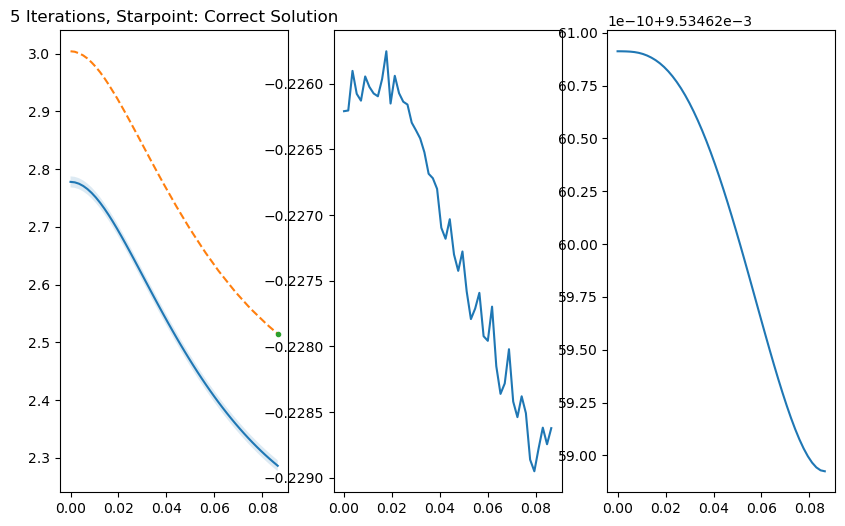

In [17]:
psi_init = psi 
N = 10                               # Number of basis functions
S = 1.0e-4*np.identity(len(R)+1)     # Sigma matrix
L = 1.0e-3*np.identity(N+1)             # 

# Define the arrays which store the variables
iteration_steps        = 1
psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))

# Initialization
psi_mean_storage[:, 0] = psi_init

# Boundary condition value
y_BC2 = psi[-1] # np.array([1 + m[-1]/(2*R[-1])])

basis_func_matrix, design_matrix = construct_design_matrix(R, N, basis_func, laplacian)
source_term = construct_source_term(psi_init, y_BC2)

for i in tqdm(range(1, iteration_steps + 1)):
    
    # Solve the ODE
    solution_mean_primal, solution_variance_primal, _, _, A, w, _ = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)
    
    # Storage
    psi_mean_storage[:, i] = solution_mean_primal
    psi_var_storage[:,:,i] = solution_variance_primal

    # Construct the new source term
    source_term = construct_source_term(solution_mean_primal, y_BC2)

fig, ax = plt.subplots(1,3, figsize=(10,6))

ax[0].plot(R, solution_mean_primal, label="Solution from Nonlinear Problem")
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[0].fill_between(R, solution_mean_primal - solution_std, solution_mean_primal + solution_std, alpha=0.15)
ax[0].plot(R, psi, ls='--', label="Ground Truth")
ax[0].plot(np.max(R), y_BC2, marker='.', ls='none', label="Initial Condition")
ax[0].set_title("5 Iterations, Starpoint: Correct Solution")


ax[1].plot(R, solution_mean_primal - psi)

ax[2].plot(R, solution_std);

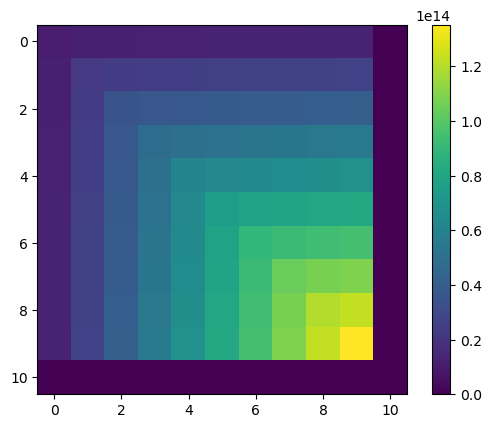

In [531]:
plt.imshow(A)
plt.colorbar()

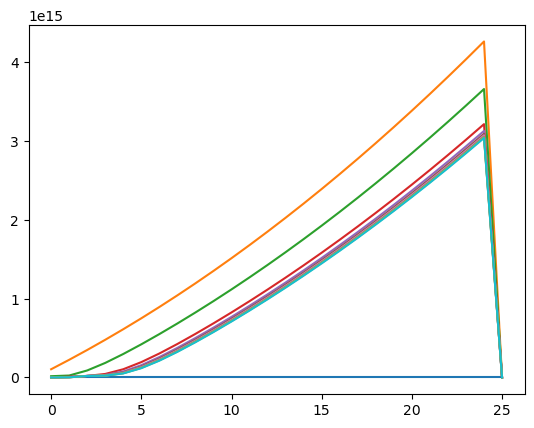

In [494]:
for i in range(iteration_steps):
    plt.plot(np.diag(L_squared_storage[:,:,i]))

### 2.2 Initialization: Gaussian Noise
It evolves in the correct direction, but never reaches the final result


00%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1051.93it/s]

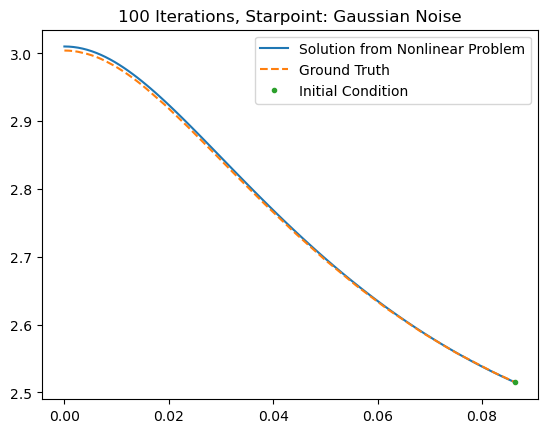

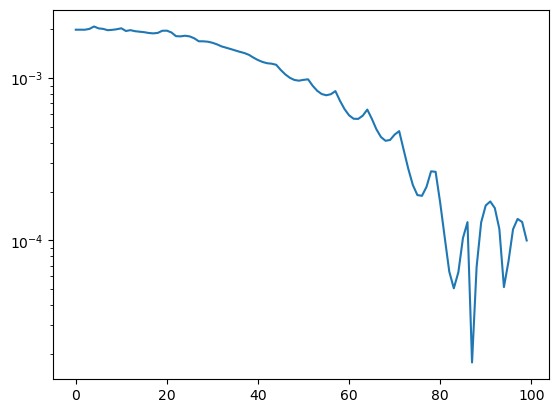

In [14]:
psi_init = np.random.normal(0, 1, len(psi))
N = 25                               # Number of basis functions
S = 1.0e-3*np.identity(len(R)+1)     # Sigma matrix
L = 1.0e-1*np.identity(N+1)             # 

# Define the arrays which store the variables
iteration_steps        = 1000
psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))
residu                 = np.zeros((len(psi), iteration_steps+1))

# Initialization
psi_mean_storage[:, 0] = psi_init

# Boundary condition value
y_BC2 = psi[-1] # np.array([1 + m[-1]/(2*R[-1])])

basis_func_matrix, design_matrix = construct_design_matrix(R, N, basis_func, laplacian)
source_term = construct_source_term(S1, psi_init, y_BC2)

for i in tqdm(range(1, iteration_steps + 1)):

    solution_mean_primal, source_func_mean_primal, _, w, _ = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)
    psi_mean_storage[:, i] = solution_mean_primal
    residu[:, i] = np.abs(source_func_mean_primal - source_term[:-1])
    source_term = construct_source_term(S1, solution_mean_primal, y_BC2)

plt.plot(R, solution_mean_primal, label="Solution from Nonlinear Problem")
plt.plot(R, psi, ls='--', label="Ground Truth")
plt.plot(np.max(R), y_BC2, marker='.', ls='none', label="Initial Condition")
plt.title("100 Iterations, Starpoint: Gaussian Noise")
plt.legend();

plt.figure(3)
plt.plot(np.abs(solution_mean_primal - psi)/psi)
plt.yscale("log")

### 2.3 Initialization: Perturbed Density


00%|████████████████████████████████████████| 100/100 [00:00<00:00, 689.00it/s]

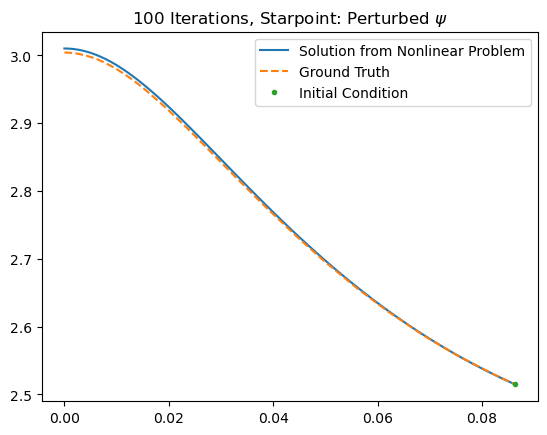

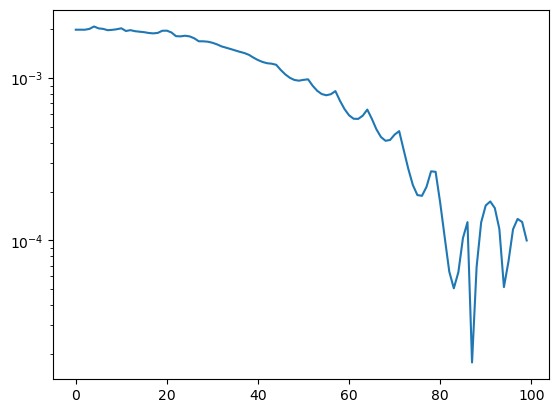

In [17]:
psi_init = perturbed_psi
N = 25                               # Number of basis functions
S = 1.0e-3*np.identity(len(R)+1)     # Sigma matrix
L = 1.0e-1*np.identity(N+1)             # 

# Define the arrays which store the variables
iteration_steps        = 100
psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))
residu                 = np.zeros((len(psi), iteration_steps+1))

# Initialization
psi_mean_storage[:, 0] = psi_init

# Boundary condition value
y_BC2 = psi[-1] # np.array([1 + m[-1]/(2*R[-1])])

basis_func_matrix, design_matrix = construct_design_matrix(R, N, basis_func, laplacian)
source_term = construct_source_term(S1, psi_init, y_BC2)

for i in tqdm(range(1, iteration_steps + 1)):

    solution_mean_primal, source_func_mean_primal, _, w, _ = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)
    psi_mean_storage[:, i] = solution_mean_primal
    residu[:, i] = np.abs(source_func_mean_primal - source_term[:-1])
    source_term = construct_source_term(S1, solution_mean_primal, y_BC2)

plt.plot(R, solution_mean_primal, label="Solution from Nonlinear Problem")
plt.plot(R, psi, ls='--', label="Ground Truth")
plt.plot(np.max(R), y_BC2, marker='.', ls='none', label="Initial Condition")
plt.title(r"100 Iterations, Starpoint: Perturbed $\psi$")
plt.legend();

plt.figure(3)
plt.plot(np.abs(solution_mean_primal - psi)/psi)
plt.yscale("log")